### Load dataset and split trainset into startified train/val dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, f1_score
)
from sklearn.preprocessing import label_binarize

RANDOM_STATE = 42
VAL_FRACTION = 0.25

# Load datasets
url_train = "https://raw.githubusercontent.com/magnus-engstroem/IE500-Data-Mining/main/Selected_data/train.csv"
train_df = pd.read_csv(url_train)
url_test = "https://raw.githubusercontent.com/magnus-engstroem/IE500-Data-Mining/main/Selected_data/test.csv"
test_df = pd.read_csv(url_test)

# Features = all except Label
X_train_full = train_df.drop(columns=["is_benign"])
y_train_full = train_df["is_benign"]

X_test = test_df.drop(columns=["is_benign"])
y_test = test_df["is_benign"]

# Validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_FRACTION,
    random_state=RANDOM_STATE,
    stratify=y_train_full
)

print("Shapes — train / val / test:", X_train.shape, X_val.shape, X_test.shape)

Shapes — train / val / test: (121096, 38) (40366, 38) (40366, 38)


### Not tuned RandomForestClassifier

In [2]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"\n=== Validation set performance  no blanced classweight===")
y_val_pred = rf.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=4))

y_pred = rf.predict(X_test)
print("=== Classification report (test) ===")
print(classification_report(y_test, y_pred, digits=4))


=== Validation set performance  no blanced classweight===
              precision    recall  f1-score   support

           0     0.9715    0.9844    0.9779     37676
           1     0.7315    0.5955    0.6566      2690

    accuracy                         0.9585     40366
   macro avg     0.8515    0.7900    0.8172     40366
weighted avg     0.9555    0.9585    0.9565     40366

=== Classification report (test) ===
              precision    recall  f1-score   support

           0     0.9711    0.9840    0.9775     37624
           1     0.7314    0.5988    0.6585      2742

    accuracy                         0.9578     40366
   macro avg     0.8513    0.7914    0.8180     40366
weighted avg     0.9549    0.9578    0.9558     40366



### RandomForestClassifier with class_weigth=balanced

In [3]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"\n=== Validation set performance balanced class weight ===")
y_val_pred = rf.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=4))

y_pred = rf.predict(X_test)
print("=== Classification report (test) ===")
print(classification_report(y_test, y_pred, digits=4))


=== Validation set performance balanced class weight ===
              precision    recall  f1-score   support

           0     0.9677    0.9873    0.9774     37676
           1     0.7513    0.5390    0.6277      2690

    accuracy                         0.9574     40366
   macro avg     0.8595    0.7631    0.8026     40366
weighted avg     0.9533    0.9574    0.9541     40366

=== Classification report (test) ===
              precision    recall  f1-score   support

           0     0.9683    0.9866    0.9774     37624
           1     0.7522    0.5569    0.6400      2742

    accuracy                         0.9574     40366
   macro avg     0.8603    0.7718    0.8087     40366
weighted avg     0.9536    0.9574    0.9545     40366



### RandomForestClassifier hyperparameter tuning with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score

def tune_rf_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42, n_iter=40):
    """
    Tune RandomForest using RandomizedSearchCV on training data.
    Evaluate on validation, select best model, retrain on train+val, evaluate test.
    """
    # 1) Parameter distributions
    param_dist = {
        'n_estimators': [200, 400, 600, 800],
        'max_depth': [None, 20, 40, 60, 80],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced']
    }

    # Use a smaller subset for tuning if data is very large (optional)
    subset_frac = 0.3
    if subset_frac < 1.0:
        X_train_sub, _, y_train_sub, _ = train_test_split(
            X_train, y_train, train_size=subset_frac, stratify=y_train, random_state=random_state
        )
    else:
        X_train_sub, y_train_sub = X_train, y_train

    # 2) RandomizedSearchCV
    rf = RandomForestClassifier(random_state=random_state, n_jobs=-1, bootstrap=True, oob_score=True)
    search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1_macro', 
        n_jobs=-1,
        random_state=random_state,
        verbose=1,
        refit=True
    )
    print("Starting hyperparameter search on training subset...")
    search.fit(X_train_sub, y_train_sub)
    print("Best parameters found:", search.best_params_)

    best_model = search.best_estimator_

    # 3) Evaluate on validation
    print("\n=== Validation set performance ===")
    y_val_pred = best_model.predict(X_val)
    print(classification_report(y_val, y_val_pred, digits=4))
    if len(np.unique(y_train)) == 2:
        proba_val = best_model.predict_proba(X_val)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, proba_val)
        pr_auc = auc(recall, precision)
        try:
            roc_auc = roc_auc_score(y_val, proba_val)
        except Exception:
            roc_auc = None
        print(f"Validation PR AUC: {pr_auc:.4f}   ROC AUC: {roc_auc if roc_auc is not None else 'N/A'}")

    # 4) Retrain on train+val
    print("\nRetraining best model on TRAIN+VAL...")
    best_model.fit(X_train_full, y_train_full)

    # 5) Evaluate on test
    print("\n=== Final evaluation on TEST set ===")
    y_test_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_test_pred, digits=4))
    if len(np.unique(y_train)) == 2:
        proba_test = best_model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, proba_test)
        pr_auc_test = auc(recall, precision)
        try:
            roc_auc_test = roc_auc_score(y_test, proba_test)
        except Exception:
            roc_auc_test = None
        print(f"Test PR AUC: {pr_auc_test:.4f}   ROC AUC: {roc_auc_test if roc_auc_test is not None else 'N/A'}")

    return best_model, search.best_params_

best_rf_model, best_params = tune_rf_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test)
print("Best RF parameters:", best_params)

Starting hyperparameter search on training subset...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

=== Validation set performance ===
              precision    recall  f1-score   support

           0     0.9836    0.9573    0.9702     37676
           1     0.5646    0.7762    0.6537      2690

    accuracy                         0.9452     40366
   macro avg     0.7741    0.8667    0.8120     40366
weighted avg     0.9557    0.9452    0.9492     40366

Validation PR AUC: 0.6826   ROC AUC: 0.9742493915051874

Retraining best model on TRAIN+VAL...

=== Final evaluation on TEST set ===
              precision    recall  f1-score   support

           0     0.9882    0.9628    0.9753     37624
           1     0.6227    0.8428    0.7163      2742

    accuracy                         0.9546     40366
   macro

### Save model

In [4]:
import joblib
import os

In [5]:

from sklearn.ensemble import RandomForestClassifier

# Create a folder in a writable location
os.makedirs("models", exist_ok=True)


best_model= RandomForestClassifier(n_estimators= 600, min_samples_split= 2, min_samples_leaf= 4, max_features = "sqrt", max_depth= None, class_weight= 'balanced')
best_model.fit(X_train_full, y_train_full)


,n_estimators,600
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:

# Save the model there
joblib.dump(best_model, "models/random_forest_tuned.pkl")


['models/random_forest_tuned.pkl']

In [7]:


# Load it later
rf_loaded = joblib.load("models/random_forest_tuned.pkl")
y_pred = rf_loaded.predict(X_test)



### Look at feature importance

In [ ]:
import shap
import numpy as np

# Use a subset of training data for explainability
subset_size = 5000
X_shap = X_train.sample(subset_size, random_state=42)

# RF feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, "columns") else [f"f{i}" for i in range(len(importances))]
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False).head(5)

# SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap)
shap_vals = np.abs(shap_values[1]).mean(axis=0)  # mean(|SHAP|) for positive class
shap_df = pd.DataFrame({"feature": feature_names, "shap_importance": shap_vals}).sort_values(
    "shap_importance", ascending=False).head(5)

# Merge top features and plot
top_features = list(set(fi_df["feature"]).union(set(shap_df["feature"])))
fi_top = fi_df[fi_df["feature"].isin(top_features)]
shap_top = shap_df[shap_df["feature"].isin(top_features)]

fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
indices = np.arange(len(top_features))

ax.barh(indices - width/2, fi_top.set_index("feature").reindex(top_features)["importance"], 
        width, label="RF Importance", color="orange")
ax.barh(indices + width/2, shap_top.set_index("feature").reindex(top_features)["shap_importance"], 
        width, label="SHAP Importance", color="blue")

ax.set_yticks(indices)
ax.set_yticklabels(top_features)
ax.set_xlabel("Importance")
ax.set_title("Top 5 Features - Random Forest vs SHAP (Training Subset)")
ax.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

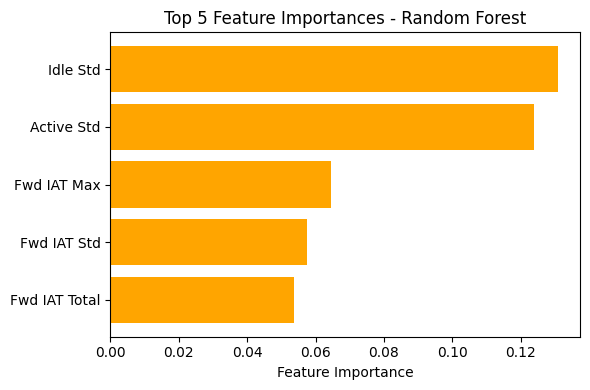

In [8]:
# Get feature importances
importances = rf_loaded.feature_importances_

# Get feature names
feature_names = X_train.columns if hasattr(X_train, "columns") else [f"f{i}" for i in range(len(importances))]

# Create DataFrame and sort by importance
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False)

# Take top 5
top5 = fi_df.head(5)

# Plot
plt.figure(figsize=(6,4))
plt.barh(top5["feature"][::-1], top5["importance"][::-1], color="orange")  # reverse for descending order
plt.xlabel("Feature Importance")
plt.title("Top 5 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()